In [1]:
# ! pip install --upgrade pip
# ! pip install --upgrade git+https://github.com/oda-hub/oda_api@local-merge
# ! pip install linked-data-latex
# ! pip install ruamel.yaml
# ! pip install pymosaic-fits


import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
from ddpaper.draftdata import DraftData
from rebin import rebin_in_bins, rebin_bins_in_bins


# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

In [2]:
# oda:version "v0.2.25"
focus_obs_name = "total_3p"

In [3]:
# Parameters
focus_obs_name = "r2559"


In [4]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [5]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [6]:
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
import ddpaper.draftdata

import logging

logging.basicConfig(level="INFO")

In [7]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))
import importlib


In [8]:
T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot).mjd - 51544
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"



In [9]:
ddpaper.draftdata.dump_notebook_globals("eventinfo", globals(), ['T0_isot', 'T0_ijd', 'source_name', 'src_coord'])        


INFO:ddpaper.draftdata:can not open ./draftdata/eventinfo.yaml due to [Errno 2] No such file or directory: './draftdata/eventinfo.yaml' FileNotFoundError(2, 'No such file or directory'), will create a new one


INFO:ddpaper.draftdata:storing in eventinfo


INFO:ddpaper.draftdata:storing T0_ijd = 8317.553472222222


INFO:ddpaper.draftdata:T0_ijd = 8317.553472222222 can be represented as 8317.553472222222
...



INFO:ddpaper.draftdata:storing T0_isot = 2022-10-09T13:17:00


INFO:ddpaper.draftdata:T0_isot = 2022-10-09T13:17:00 can be represented as '2022-10-09T13:17:00'



INFO:ddpaper.draftdata:storing source_name = GRB221009A


INFO:ddpaper.draftdata:source_name = GRB221009A can be represented as GRB221009A
...



INFO:ddpaper.draftdata:storing src_coord = <SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>


INFO:ddpaper.draftdata:src_coord = <SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)> can be represented as !astropy.coordinates.sky_coordinate.SkyCoord
dec: !astropy.coordinates.Latitude
  unit: &id001 !astropy.units.Unit {unit: deg}
  value: 19.773083333333332
frame: icrs
ra: !astropy.coordinates.Longitude
  unit: *id001
  value: 288.26429166666657
  wrap_angle: !astropy.coordinates.Angle
    unit: *id001
    value: 360.0
representation_type: spherical



{'T0_ijd': 8317.553472222222,
 'T0_isot': '2022-10-09T13:17:00',
 'source_name': 'GRB221009A',
 'src_coord': <SkyCoord (ICRS): (ra, dec) in deg
     (288.26429167, 19.77308333)>}

In [10]:
# set!

# focus_obs_name = "total_3p"
# focus_obs_name = "r2562"
# focus_obs_name = "r2560"
# focus_obs_name = "r2559"
# focus_obs_name = "r2558"
# focus_obs_name = "total_3p"

obs_by_name = dict(
    total_3p=dict(
        obs_T1_isot = "2022-10-08T00:39:04",
        obs_T2_isot = "2022-10-23T08:02:00"
    ))

for r in 2558, 2559, 2560, 2561, 2562:
    t1, t2 = [Time(float(t)+51544, format='mjd').isot for t in requests.get(f'https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/REVNUM/{r}/IJD').text.split()[1:]]
    obs_by_name[f'r{r}']=dict(
        obs_T1_isot = t1,
        obs_T2_isot = t2
    )

obs_by_name['r25589']=dict(
        obs_T1_isot = obs_by_name['r2558']['obs_T1_isot'],
        obs_T2_isot = obs_by_name['r2559']['obs_T2_isot']
    )


focus_obs = obs_by_name[focus_obs_name]

with DraftData() as dd:
    if 'obs' not in dd:
        dd['obs'] = {}
    dd['obs'][focus_obs_name] = focus_obs


obs_draft_data = DraftData(focus_obs_name)

dd['obs'][focus_obs_name]

{'obs_T1_isot': '2022-10-11T09:37:24.184',
 'obs_T2_isot': '2022-10-14T01:28:14.184'}

In [11]:

# for obs_name, obs in obs_by_name.items():
#     requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/sc/{obs['obs_T1_isot']}/{obs['obs_T2_isot']}")

In [12]:
scw_dict_cons = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/{focus_obs['obs_T1_isot']}/{focus_obs['obs_T2_isot']}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=10&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())
scw_dict_nrt = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/nrt/{focus_obs['obs_T1_isot']}/{focus_obs['obs_T2_isot']}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=10&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())

scw_dict_cons['SCWVER'] = "001"
scw_dict_nrt['SCWVER'] = "000"

scw_dict = pd.concat([scw_dict_cons, scw_dict_nrt])
            

scw_list = []
for i, r in scw_dict[scw_dict['SW_TYPE'].str.strip() == "POINTING"].iterrows():
    scw_list.append(r['SWID'] + "." + r['SCWVER'])

print("\n".join(scw_list))

with obs_draft_data as dd:
    dd['telapse_sum_s'] = np.sum(scw_dict.TELAPSE[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['tstart_ijd'] = np.min(scw_dict.TSTART[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['tstop_ijd'] = np.max(scw_dict.TSTOP[scw_dict['SW_TYPE'].str.strip() == "POINTING"])    
    dd['telapse_total_s'] = (dd['tstop_ijd'] - dd['tstart_ijd'])*24*3600
    
dd

INFO:ddpaper.draftdata:can not open ./draftdata/r2559.yaml due to [Errno 2] No such file or directory: './draftdata/r2559.yaml' FileNotFoundError(2, 'No such file or directory'), will create a new one


255900010010.001
255900020010.001
255900030010.001
255900040010.001
255900050010.001
255900060010.001
255900070010.001
255900080010.001
255900090010.001
255900100010.001
255900110010.001
255900120010.001
255900130010.001
255900140010.001
255900150010.001
255900160010.001
255900170010.001
255900180010.001
255900190010.001
255900200010.001
255900210010.001
255900220010.001
255900230010.001
255900240010.001
255900250010.001
255900260010.001
255900270010.001
255900280010.001
255900290010.001
255900300010.001
255900310010.001
255900320010.001
255900330010.001
255900340010.001
255900350010.001
255900360010.001


{'telapse_sum_s': 119376.07927856734,
 'tstart_ijd': 8319.56830667189,
 'tstop_ijd': 8321.04139792801,
 'telapse_total_s': 127275.08452868205}

In [13]:
disp = oda_api.api.DispatcherAPI()
# disp_collection = oda_api.api.DispatcherAPICollection(use_local_cache=True)
disp.use_local_cache = True
disp.wait = True

source_images = {}

pars = []

for i in ['isgri', 'jemx1', 'jemx2']:
    instrument = i[:-1] if i.startswith('jemx') else i
    product = instrument + "_image"
    jemx_num= int(i[-1]) if i.startswith('jemx') else 1
    E1_keV, E2_keV = (3, 30) if i.startswith('jemx') else (28, 80)
    

    source_images[i] = disp.get_product(
        instrument=instrument,
        product=product,
        E1_keV=E1_keV,
        E2_keV=E2_keV,
        jemx_num=jemx_num,
        integral_data_rights="all-private",
        scw_list=scw_list,
        token=oda_api.token.discover_token()
    #     src_coord
    )


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/api.py:1265: UserWarning: 
----------------------------------------------------------------------------
the parameter: jemx_num   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
----------------------------------------------------------------------------

  warnings.warn(msg)
trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_e42387f54e3e8648.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_e42387f54e3e8648.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_e42387f54e3e8648.json.gz in 0.08 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_e42387f54e3e8648.json.gz in 0.08 seconds


session: TZRZLQ92PN647N27 job: 397f3384355494aa


INFO:oda_api.api:session: TZRZLQ92PN647N27 job: 397f3384355494aa



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 397f3384355494aa


INFO:oda_api.api.dispatcherapi:... assigned job id: 397f3384355494aa


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


query complete: terminating


INFO:oda_api.api.dispatcherapi:query complete: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2077f73f68ad9b6c.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2077f73f68ad9b6c.json.gz


Please note that argument jemx_num is not used


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2077f73f68ad9b6c.json.gz in 0.27 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2077f73f68ad9b6c.json.gz in 0.27 seconds


session: JHCUDK73CPO55K8X job: 45e7a8ba1935e623


INFO:oda_api.api:session: JHCUDK73CPO55K8X job: 45e7a8ba1935e623



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 45e7a8ba1935e623


INFO:oda_api.api.dispatcherapi:... assigned job id: 45e7a8ba1935e623


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


query complete: terminating


INFO:oda_api.api.dispatcherapi:query complete: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d569f3247a0ead61.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d569f3247a0ead61.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d569f3247a0ead61.json.gz in 0.23 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d569f3247a0ead61.json.gz in 0.23 seconds


session: JHCUDK73CPO55K8X job: 63c6cbdf68f723f9


INFO:oda_api.api:session: JHCUDK73CPO55K8X job: 63c6cbdf68f723f9



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 63c6cbdf68f723f9


INFO:oda_api.api.dispatcherapi:... assigned job id: 63c6cbdf68f723f9


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


query complete: terminating


INFO:oda_api.api.dispatcherapi:query complete: terminating


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'.


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


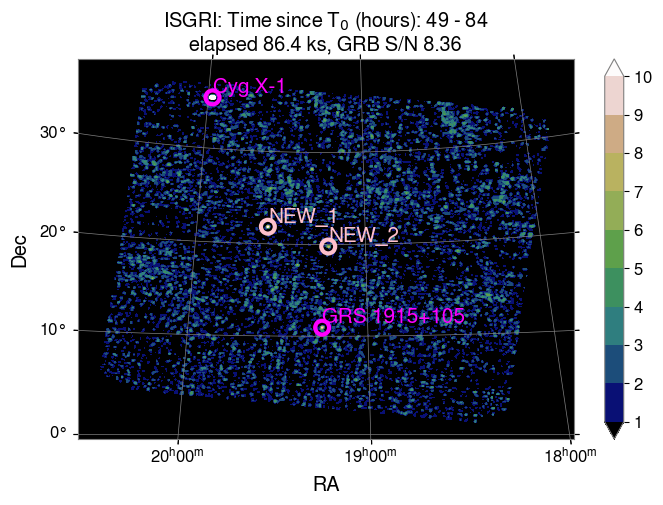

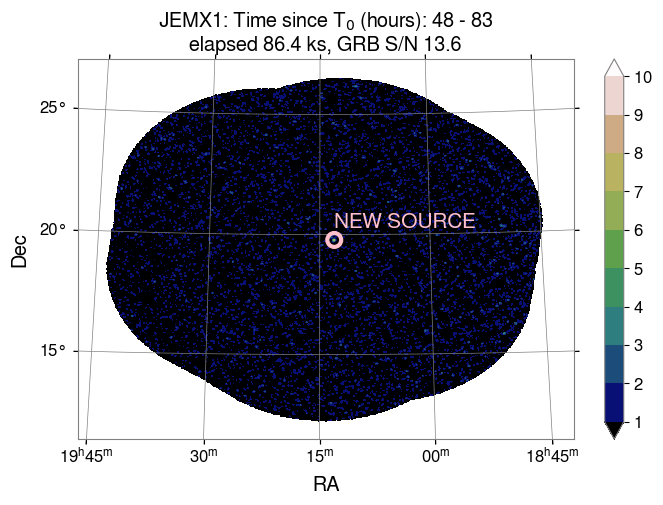

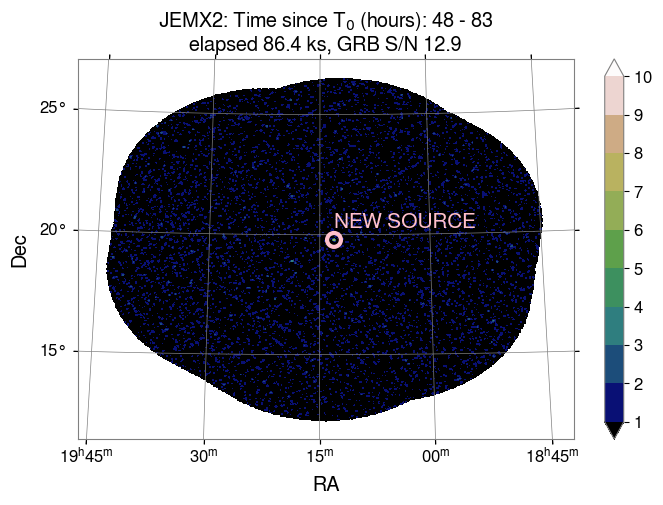

In [14]:
fns = []

for name, image in source_images.items():
    if image:
        h = image.mosaic_image_0_mosaic.data_unit[4].header
        t = image.dispatcher_catalog_1.table        
        m = SkyCoord(t['ra'], t['dec']).separation(src_coord).arcmin <10

        try:
            snr = t[m]['significance'][0]
        except:
            snr = 0

        t = Time(h['TSTART'] + 51544, format='mjd').isot
        im = oda_api.plot_tools.OdaImage(image)
        fns.append(im.write_fits(f'{name}_{focus_obs_name}_'))
        im.show(sliders=False)
        plt.title(f"{name.upper()}: Time since T$_0$ (hours): {(h['TSTART'] - T0_ijd)*24:.2g} - {(h['TSTOP'] - T0_ijd)*24:.2g}\n"
                  f"elapsed {int(h['TSTOP'] - h['TSTART'])*24*3.6:.3g} ks, GRB S/N {snr:.3g}")

In [15]:
# ! pip install pymosaic-fits
import mosaic
import importlib
importlib.reload(mosaic)
mosa = mosaic.FITsMosaic()

from astropy.io import fits

tag = focus_obs_name

for ins in 'jemx1', 'jemx2': #, 'isgri':
    f = fits.open(f"{ins}_{tag}_mosaic.fits")

    new_hdus = [fits.PrimaryHDU()]

    for i in f[2:-1]:

        for k, v in dict(i.header).items():
            if str(v).strip() == 'Real':
                print('patching', k)
                i.header[k] = 1000

        if i.header.get('IMATYPE', '') == 'RECONSTRUCTED':
            i.header['IMATYPE'] = 'INTENSITY'

        i.header['TELAPSE'] = 1000
        i.header['TFIRST'] = 0
        i.header['TLAST'] = 1000
        i.header['E_MIN'] = 3.04
        i.header['E_MAX'] = 29.84
        print(i.header.get('IMATYPE', '??'))
        new_hdus.append(i)
        
        
    fits.HDUList(new_hdus).writeto(f"{ins}_{tag}_mosaic_mod.fits", overwrite=True)
    mosa.add(fits.open(f"{ins}_{tag}_mosaic_mod.fits"))

mosa.writeto(f'jemxX_{tag}_mosaic.fits')


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


INFO:root:first mosaic


INFO:root:adding mosaic


patching TELAPSE
INTENSITY
patching TELAPSE
VARIANCE
patching TELAPSE
SIGNIFICANCE
patching TELAPSE
EXPOSURE
patching TELAPSE
INTENSITY
patching TELAPSE
VARIANCE
patching TELAPSE
SIGNIFICANCE
patching TELAPSE
EXPOSURE


In [16]:
cat = source_images['isgri'].dispatcher_catalog_1

toremove = []
for i, r in enumerate(cat.table.iterrows()):
    print(r)
    if r[1].startswith('NEW_') or r[1].startswith('GRB') or r[1].startswith('SGR'):
        toremove.append(i)        

cat.table.add_row(
{
    'src_names': source_name,
    'ra': src_coord.ra.deg,
    'dec': src_coord.dec.deg,
    # 'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})

sgr = SkyCoord.from_name('SGR 1935+2154')
cat.table.add_row(
{
    'src_names': 'SGR 1935+2154',
    'ra': sgr.ra.deg,
    'dec': sgr.dec.deg,
    # 'ISGRI_FLAG': 1,
    'FLAG': 1,
    'ERR_RAD': 0.05,    
})


cat.table.remove_rows(toremove)

cat.table

(8, 'Cyg X-1', 98.3636474609375, 299.5924987792969, 35.21561813354492, -32768, 2, 0, 0.0002800000074785203)
(9, 'GRS 1915+105', 10.299225807189941, 288.838134765625, 10.922883987426758, -32768, 2, 0, 0.0002800000074785203)
(78, 'NEW_1', 13.115005493164062, 293.7308044433594, 21.87287139892578, -32767, 0, 0, None)
(79, 'NEW_2', 8.364216804504395, 288.3116149902344, 19.782390594482422, -32767, 0, 0, None)


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str13,float64,float64,float64,int64,int64,int64,object
8,Cyg X-1,98.3636474609375,299.5924987792969,35.21561813354492,-32768,2,0,0.0002800000074785203
9,GRS 1915+105,10.299225807189941,288.838134765625,10.922883987426758,-32768,2,0,0.0002800000074785203
0,GRB221009A,0.0,288.26429166666657,19.773083333333332,0,0,1,0.05
0,SGR 1935+2154,0.0,293.732,21.89672222,0,0,1,0.05


In [17]:
from astropy.table import Table

m_source = [not s.startswith('NEW') for s in cat.table['src_names']]
cat.table = Table(cat.table[m_source])

cat.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[8, 9, 0, 0], ["Cyg X-1", "GRS 1915+105", "GRB221009A", "SGR 1935+2154"], [98.3636474609375, 10.299225807189941, 0.0, 0.0], [299.5924987792969, 288.838134765625, 288.26429166666657, 293.732], [35.21561813354492, 10.922883987426758, 19.773083333333332, 21.89672222], [-32768, -32768, 0, 0], [2, 2, 0, 0], [0, 0, 1, 1], [0.0002800000074785203, 0.0002800000074785203, 0.05, 0.05]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U13"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

In [18]:

# from ddpaper.draftdata import DraftData

with obs_draft_data as dd:
    dd['obs'] = dict(
    )


In [19]:
import time


source_products = {}

while len(source_products) == 0 or None in list(source_products.values()):
    for product in [
            "isgri_lc",
            "isgri_spectrum",
            "isgri_image",
            "isgrihe_image",
            "jemx1_lc",
            "jemx1_spectrum",
            "jemx1_image",
            "jemx2_lc",
            "jemx2_spectrum",
            "jemx2_image",
        ]:
        disp.wait = False
        
        if 'jemx' in product:
            e1, e2 = 4, 30
        else:
            e1, e2 = 28, 80
        
        jnum = 1
        product_pass = product

        if 'jemx1' in product:
            jnum=1
            product_pass = product.replace("jemx1_", "jemx_")
        elif 'jemx2' in product:
            jnum=2
            product_pass = product.replace("jemx2_", "jemx_")
        elif 'isgrihe' in product:
            e1, e2 = 80, 200
            product_pass = product.replace("isgrihe_", "isgri_")
        
        source_products[product] = disp.get_product(
            instrument=product_pass.split("_")[0],
            product=product_pass,
            osa_version="OSA11.2",
            scw_list=scw_list,
            token = oda_api.token.discover_token(),
            E1_keV=e1,
            E2_keV=e2,
            jemx_num=jnum,
            selected_catalog=cat.get_api_dictionary(),
            integral_data_rights="all-private",
        )
    time.sleep(5)

found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/api.py:1265: UserWarning: 
----------------------------------------------------------------------------
the parameter: jemx_num   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'time_bin', 'time_bin_format']
----------------------------------------------------------------------------

  warnings.warn(msg)
trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_c49d90c54e659eaf.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_c49d90c54e659eaf.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_c49d90c54e659eaf.json.gz in 0.00 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_c49d90c54e659eaf.json.gz in 0.00 seconds


session: 1MQYH4YIVJM2JB8O job: c1f741e93981c1e0


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: c1f741e93981c1e0



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: c1f741e93981c1e0


INFO:oda_api.api.dispatcherapi:... assigned job id: c1f741e93981c1e0


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


Please note that argument jemx_num is not used


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/api.py:1265: UserWarning: 
----------------------------------------------------------------------------
the parameter: jemx_num   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV']
----------------------------------------------------------------------------

  warnings.warn(msg)
trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e684b43568daf8b.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e684b43568daf8b.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e684b43568daf8b.json.gz in 0.45 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e684b43568daf8b.json.gz in 0.45 seconds


session: 1MQYH4YIVJM2JB8O job: 35cc15231a4786e7


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 35cc15231a4786e7



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 35cc15231a4786e7


INFO:oda_api.api.dispatcherapi:... assigned job id: 35cc15231a4786e7


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


Please note that argument jemx_num is not used


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/api.py:1265: UserWarning: 
----------------------------------------------------------------------------
the parameter: jemx_num   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
----------------------------------------------------------------------------

  warnings.warn(msg)
trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_a0b7529050a97f99.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_a0b7529050a97f99.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_a0b7529050a97f99.json.gz in 0.06 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_a0b7529050a97f99.json.gz in 0.06 seconds


session: 1MQYH4YIVJM2JB8O job: 6a27deb020577410


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 6a27deb020577410



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 6a27deb020577410


INFO:oda_api.api.dispatcherapi:... assigned job id: 6a27deb020577410


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/api.py:1265: UserWarning: 
----------------------------------------------------------------------------
the parameter: jemx_num   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T_format', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
----------------------------------------------------------------------------

  warnings.warn(msg)


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2f80fc8d7d07ff7f.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2f80fc8d7d07ff7f.json.gz


Please note that argument jemx_num is not used


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2f80fc8d7d07ff7f.json.gz in 0.06 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2f80fc8d7d07ff7f.json.gz in 0.06 seconds


session: 1MQYH4YIVJM2JB8O job: b92ab8a3a596ea6b


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: b92ab8a3a596ea6b



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: b92ab8a3a596ea6b


INFO:oda_api.api.dispatcherapi:... assigned job id: b92ab8a3a596ea6b


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bfe4b71a4f501ce0.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bfe4b71a4f501ce0.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bfe4b71a4f501ce0.json.gz in 0.00 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bfe4b71a4f501ce0.json.gz in 0.00 seconds


session: 1MQYH4YIVJM2JB8O job: a51a20d6fd5fdd8d


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: a51a20d6fd5fdd8d



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: a51a20d6fd5fdd8d


INFO:oda_api.api.dispatcherapi:... assigned job id: a51a20d6fd5fdd8d


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


Please note that argument jemx_num is not used


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bf4aa6619938ef11.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bf4aa6619938ef11.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bf4aa6619938ef11.json.gz in 0.01 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_bf4aa6619938ef11.json.gz in 0.01 seconds


session: 1MQYH4YIVJM2JB8O job: d2c7419a72d94203


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: d2c7419a72d94203



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: d2c7419a72d94203


INFO:oda_api.api.dispatcherapi:... assigned job id: d2c7419a72d94203


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e0976a379572859.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e0976a379572859.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e0976a379572859.json.gz in 0.19 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_9e0976a379572859.json.gz in 0.19 seconds


session: 1MQYH4YIVJM2JB8O job: 70c75b08f8127fda


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 70c75b08f8127fda



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 70c75b08f8127fda


INFO:oda_api.api.dispatcherapi:... assigned job id: 70c75b08f8127fda


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_ecddfcd927f95316.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_ecddfcd927f95316.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_ecddfcd927f95316.json.gz in 0.00 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_ecddfcd927f95316.json.gz in 0.00 seconds


session: 1MQYH4YIVJM2JB8O job: 85054cad00f6d48d


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 85054cad00f6d48d



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 85054cad00f6d48d


INFO:oda_api.api.dispatcherapi:... assigned job id: 85054cad00f6d48d


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2c2d9b5ae52c9742.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2c2d9b5ae52c9742.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2c2d9b5ae52c9742.json.gz in 0.01 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_2c2d9b5ae52c9742.json.gz in 0.01 seconds


session: 1MQYH4YIVJM2JB8O job: 034520b3cf623123


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 034520b3cf623123



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 034520b3cf623123


INFO:oda_api.api.dispatcherapi:... assigned job id: 034520b3cf623123


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


INFO:oda_api.token:found token in TokenLocation.FILE_HOME your token payload: {
    "email": "vladimir.savchenko+prod-test@gmail.com",
    "exp": 1676412105,
    "name": "VolodymyrSavchenkoProdTest",
    "roles": "authenticated user, administrator, content manager, integral-private-qla, unige-hpc-full, public-pool-hpc, renku contributor, gallery contributor, job manager",
    "sub": "vladimir.savchenko+prod-test@gmail.com"
}


token expires in 72.2 h


INFO:oda_api.token:token expires in 72.2 h


please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`


To disable this message you can pass `.get_product(..., silent=True)`


trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d9c746156b8c4e7d.json.gz


INFO:oda_api.api:trying to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d9c746156b8c4e7d.json.gz


managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d9c746156b8c4e7d.json.gz in 0.25 seconds


INFO:oda_api.api:managed to load result from /home/savchenk/.cache/oda-api/cache/oda_api_data_collection_d9c746156b8c4e7d.json.gz in 0.25 seconds


session: 1MQYH4YIVJM2JB8O job: 8c518c56e341a986


INFO:oda_api.api:session: 1MQYH4YIVJM2JB8O job: 8c518c56e341a986



... query status prepared => done


INFO:oda_api.api.dispatcherapi:
... query status prepared => done


... assigned job id: 8c518c56e341a986


INFO:oda_api.api.dispatcherapi:... assigned job id: 8c518c56e341a986


query COMPLETED SUCCESSFULLY (state done)


INFO:oda_api.api.dispatcherapi:query COMPLETED SUCCESSFULLY (state done)


non-waiting dispatcher: terminating


INFO:oda_api.api.dispatcherapi:non-waiting dispatcher: terminating


In [20]:
source_products

{'isgri_lc': <oda_api.api.DataCollection at 0x7ff89fdf1c70>,
 'isgri_spectrum': <oda_api.api.DataCollection at 0x7ff89d482160>,
 'isgri_image': <oda_api.api.DataCollection at 0x7ff89fed8490>,
 'isgrihe_image': <oda_api.api.DataCollection at 0x7ff89d29bdc0>,
 'jemx1_lc': <oda_api.api.DataCollection at 0x7ff89fdf1580>,
 'jemx1_spectrum': <oda_api.api.DataCollection at 0x7ff8a03c25e0>,
 'jemx1_image': <oda_api.api.DataCollection at 0x7ff89fe845e0>,
 'jemx2_lc': <oda_api.api.DataCollection at 0x7ff89fe84730>,
 'jemx2_spectrum': <oda_api.api.DataCollection at 0x7ff89e5619d0>,
 'jemx2_image': <oda_api.api.DataCollection at 0x7ff89e5075e0>}

In [21]:
d = source_products['isgrihe_image']
d.dispatcher_catalog_1.get_api_dictionary()

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[0, 4, 5], ["Cyg X-1", "NEW_3", "NEW_4"], [22.7838191986084, 7.272744655609131, 7.290521144866943], [299.5967712402344, 278.67877197265625, 278.771240234375], [35.206703186035156, 4.258154392242432, 5.322248935699463], [-32768, -32767, -32767], [2, 0, 0], [0, 0, 0], [0.0, null, null]], "cat_column_names": ["meta_ID", "src_names", "significance", "ra", "dec", "NEW_SOURCE", "ISGRI_FLAG", "FLAG", "ERR_RAD"], "cat_column_descr": [["meta_ID", "<i8"], ["src_names", "<U7"], ["significance", "<f8"], ["ra", "<f8"], ["dec", "<f8"], ["NEW_SOURCE", "<i8"], ["ISGRI_FLAG", "<i8"], ["FLAG", "<i8"], ["ERR_RAD", "|O"]], "cat_lat_name": "dec", "cat_lon_name": "ra"}'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-OBS format 'UTC_format'.
Invalid DATE-END format 'UTC_format''.


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'.


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59863.612558 from DATE-OBS.
Set MJD-END to 59865.040590 from DATE-END'.


no GRB here!


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


no GRB here!


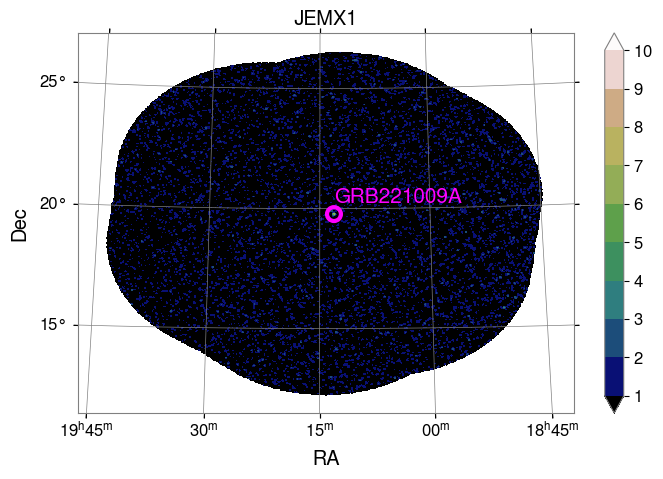

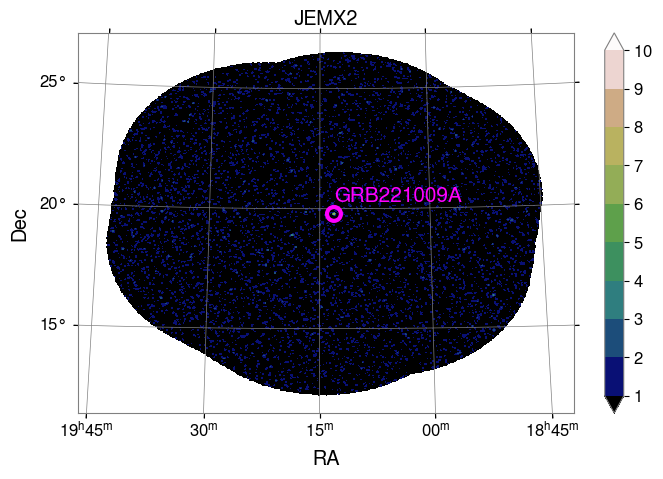

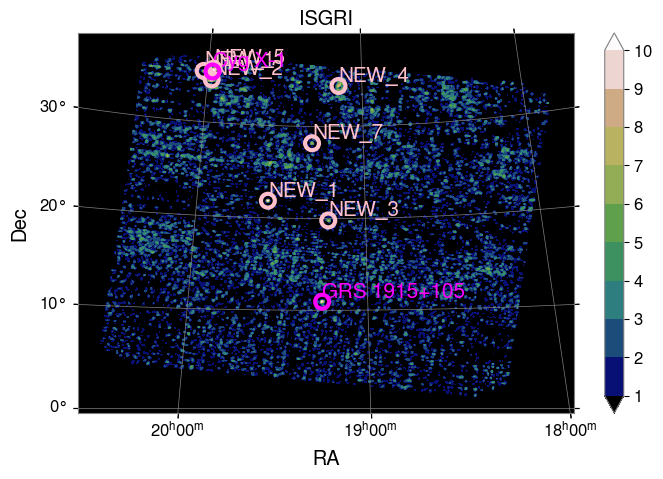

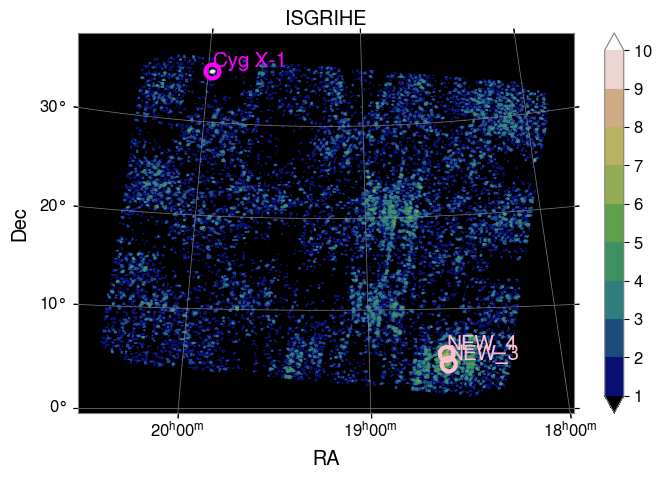

In [22]:
for instrument in 'jemx1', 'jemx2', 'isgri', 'isgrihe':
    p = source_products[instrument + '_image']
    oda_api.plot_tools.OdaImage(p).show(sliders=False) #, header="JEM-X")
    fns.append(oda_api.plot_tools.OdaImage(p).write_fits(instrument + "_"))

    name = instrument.upper() #.replace('JEMX', 'JEM-X')
     
    plt.title(name)
    plt.savefig(f"figs/{instrument}.png")

    with obs_draft_data as dd:
        try:
            dd[instrument] = {'snr': float(p.dispatcher_catalog_1.table[p.dispatcher_catalog_1.table['src_names'] == "GRB221009A"]['significance'][0])}
        except IndexError:
            print("no GRB here!")
        


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


fn: figs/lc_jemx1_grb221009a.pdf


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


fn: figs/lc_jemx2_grb221009a.pdf


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/oda_api/plot_tools.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.show()


fn: figs/lc_isgri_grb221009a.pdf


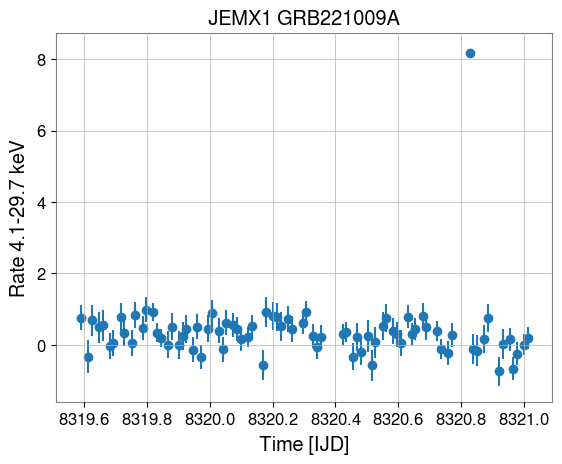

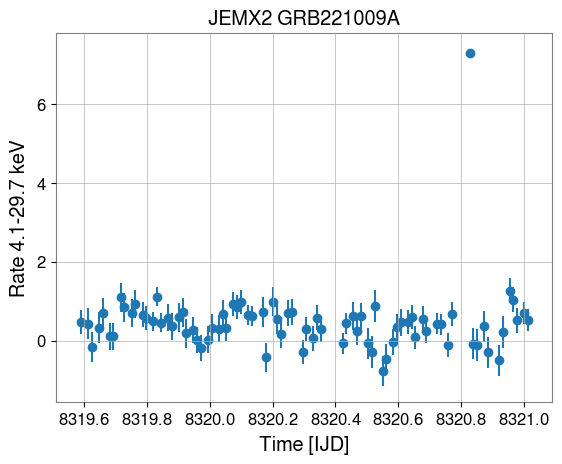

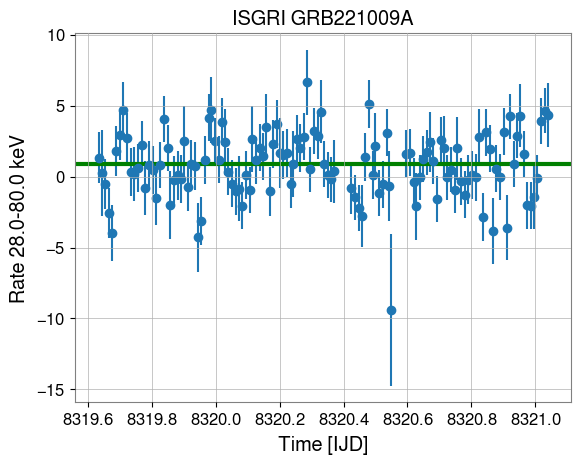

In [23]:
import importlib
import re

importlib.reload(oda_api.plot_tools)

for name in ['GRB221009A']: #, 'SGR 1935+2154':
    name_stub = re.sub("[^0-9a-zA-Z]", "", name).lower()

    for instrument in 'jemx1', 'jemx2', 'isgri':
        d = source_products[instrument + '_lc']
        fns.append(oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).write_fits(name))
        oda_api.plot_tools.OdaLightCurve(source_products[instrument + '_lc']).show(in_source_name=name)
        plt.title(instrument.upper() + " " + name)
        fn = f"figs/lc_{instrument}_{name_stub}.pdf"
        print("fn:", fn)
        plt.savefig(fn)


In [24]:
for instrument in 'jemx1', 'jemx2', 'isgri':
    p = source_products[instrument + '_spectrum']
    fns.append(oda_api.plot_tools.OdaSpectrum(source_products[instrument + '_spectrum']).write_fits('GRB221009A', file_suffix="_" + focus_obs_name))
    fns.append(fns[-1][0].replace("spectrum", "rmf"))
    fns.append(fns[-2][0].replace("spectrum", "arf"))

    print(fns[-3:])
    
    spec = getattr(p, [l['prod_name'] for l in p.as_list() if l['meta_data:']['src_name'] == 'GRB221009A'][0])
    
    with obs_draft_data as dd:
        if instrument not in dd:
            dd[instrument] = {}
        dd[instrument]['exposure_s'] = spec.data_unit[1].header['EXPOSURE']

Saving spectrum ./JMX1_spectrum_GRB221009A_r2559.fits with rmf ./JMX1_rmf_GRB221009A_r2559.fits and arf ./JMX1_arf_GRB221009A_r2559.fits


INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX1_spectrum_GRB221009A_r2559.fits with rmf ./JMX1_rmf_GRB221009A_r2559.fits and arf ./JMX1_arf_GRB221009A_r2559.fits


Saving spectrum ./JMX2_spectrum_GRB221009A_r2559.fits with rmf ./JMX2_rmf_GRB221009A_r2559.fits and arf ./JMX2_arf_GRB221009A_r2559.fits


INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./JMX2_spectrum_GRB221009A_r2559.fits with rmf ./JMX2_rmf_GRB221009A_r2559.fits and arf ./JMX2_arf_GRB221009A_r2559.fits


Saving spectrum ./IBIS_spectrum_GRB221009A_r2559.fits with rmf ./IBIS_rmf_GRB221009A_r2559.fits and arf ./IBIS_arf_GRB221009A_r2559.fits


INFO:oda_api.plot_tools.odaspectrum:Saving spectrum ./IBIS_spectrum_GRB221009A_r2559.fits with rmf ./IBIS_rmf_GRB221009A_r2559.fits and arf ./IBIS_arf_GRB221009A_r2559.fits


[('./JMX1_spectrum_GRB221009A_r2559.fits', 59863.56830667189, 59865.000159474104, 89212.4747163125), './JMX1_rmf_GRB221009A_r2559.fits', './JMX1_arf_GRB221009A_r2559.fits']
[('./JMX2_spectrum_GRB221009A_r2559.fits', 59863.56830667189, 59865.000159474104, 85939.4863106728), './JMX2_rmf_GRB221009A_r2559.fits', './JMX2_arf_GRB221009A_r2559.fits']


[('./IBIS_spectrum_GRB221009A_r2559.fits', 59863.61336457238, 59865.04139792801, 67351.82759768004), './IBIS_rmf_GRB221009A_r2559.fits', './IBIS_arf_GRB221009A_r2559.fits']


In [25]:
with obs_draft_data as dd:
    dd['joint_fit'] = dict(
        e1_keV=3,
        e2_keV=80,
        flux_ecs = 4.4263e-10, # ergs/cm^2/s) range (3.0000 - 80.000 keV
        flux_ecs_err_68p = (4.215e-10 - 4.4263e-10, 4.670e-10 - 4.4263e-10),
        slope = 2.15041,
        slope_err_90p = (-0.0712388,0.0841283)
    )

[]

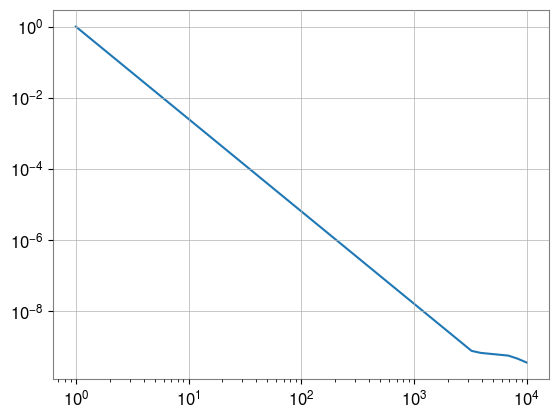

In [26]:
T0bat = Time('2022-10-09 14:10:17')


def xrt_decay(t):
    # #32671
    offset_s = ((T0bat.mjd - 51544) - T0_ijd)*24*3600
    slopes = """Alpha_1 : 2.6 (+0.4, -0.7)
    Tbreak_1: 177.4 (+2.0, -9.6)
    Alpha_2 : 0.144 (+0.022, -0.026)
    Tbreak_2: 610 (+84, -78)
    Alpha_3 : 0.31 (+0.04, -0.03)
    Tbreak_3: 4060 [+0.23, -0.19])
    Alpha_4 : 1.357 (+/-0.010)"""

    slopes =  {s.split(":")[0].strip(): float(s.split(":")[1].split()[0].strip()) for s in slopes.split("\n")}

    for k in slopes:
        if k.startswith('Tbr'):
            slopes[k] += offset_s

    r = t**(-slopes['Alpha_1'])

    m = t > slopes['Tbreak_1'] 
    rn1 = slopes['Tbreak_1']**(-slopes['Alpha_1']) / slopes['Tbreak_1']**(-slopes['Alpha_2'])
    r[m] = t[m]**(-slopes['Alpha_2']) * rn1

    m = t > slopes['Tbreak_2']
    rn2 = slopes['Tbreak_2']**(-slopes['Alpha_2']) / slopes['Tbreak_2']**(-slopes['Alpha_3']) 
    r[m] = t[m]**(-slopes['Alpha_3']) * rn1 * rn2


    m = t > slopes['Tbreak_3']
    rn3 = slopes['Tbreak_3']**(-slopes['Alpha_3']) / slopes['Tbreak_3']**(-slopes['Alpha_4']) 
    r[m] = t[m]**(-slopes['Alpha_4']) * rn1 * rn2 * rn3
    
    return r


t = np.logspace(0,4)

plt.figure()

plt.plot(
    t,
    xrt_decay(t)
)

plt.loglog()


/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/savchenk/miniconda-recent/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_2264320/2318548218.py:24: RuntimeWarning: invalid value encountered in double_scalars
  rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x)),


(1.0, 2.0)

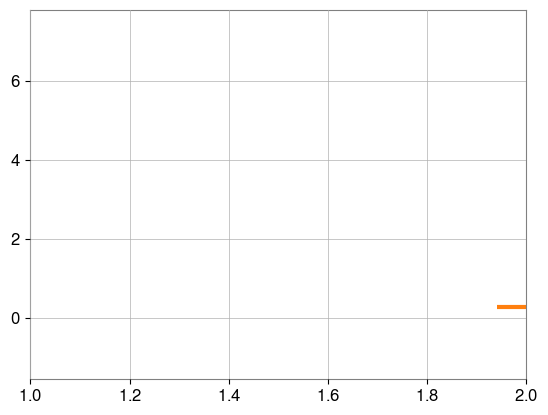

In [27]:

plt.figure()

d_j1 = fits.open("JMX1_lc_GRB221009A.fits")[1].data
d_j2 = fits.open("JMX2_lc_GRB221009A.fits")[1].data
d_i = fits.open("IBIS_lc_GRB221009A.fits")[1].data

d = d_j2
plt.errorbar(d['TIME'] - T0_ijd, d['RATE'],d['ERROR'])

m = d['TIME'] < 8319.5

# plt.errorbar(
#     np.mean(d['TIME'][m]) - T0_ijd, 
#     np.sum(d['RATE'][m])/np.sum(m),
#     (np.sum(d['ERROR'][m]**2)**0.5/np.sum(m)), lw=3)

T = np.logspace(-1, 1, 60)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

plt.errorbar(
    Tc, 
    rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T),
    rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x)),
    xerr=dT,
    ls="",
     lw=3)


plt.xlim([1,2])
# plt.ylim([0,5])

[]

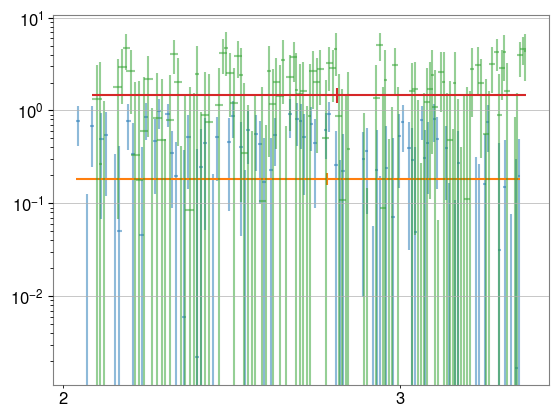

In [28]:

rebinned_lc_by_name = {}


for t, dt, r, re, f, n, T in [
    # (d_j1['TIME'], d_j1['TIMEDEL']/2, (d_j1['RATE'] + d_j2['RATE'])/2, (d_j1['ERROR']**2 + d_j1['ERROR']**2)**0.5/2, 1, 'JEMX1+2', np.logspace(-0.2, 1, 35)),
    # (d_j1['TIME'], d_j1['TIMEDEL']/2, d_j1['RATE'], d_j1['ERROR'], 1, 'JEMX1', np.logspace(-1, 1, 10000)),
    (d_j1['TIME'], d_j1['TIMEDEL']/2, d_j1['RATE'], d_j1['ERROR'], 1, 'JEMX1', np.logspace(-0.1, 1, 4)),
    # (d_j2['TIME'], d_j2['TIMEDEL']/2, d_j2['RATE'], d_j2['ERROR'], 1, 'JEMX2', np.logspace(-0.3, 1, 40)),
    (d_i['TIME'], d_i['TIMEDEL'],d_i['RATE'], d_i['ERROR'], 0.01, 'ISGRI', np.logspace(-0.1, 1, 4)),
]:    
    m = r < 6 # noisy scw?
    m &= re < 4 # noisy scw?
    m &= dt > 0
    t = t - T0_ijd

    plt.errorbar(t[m], r[m], re[m], xerr=dt[m], alpha=0.5, ls="")

    Tc, dT, X, dX = rebin_bins_in_bins(t[m], dt[m], r[m], re[m], T)

    
    # plt.errorbar(t, r,re,         # xerr=d['TIMEDEL']/2, 
    #     ls="", label=n, alpha=0.2)

    plt.errorbar(
        Tc,
        X,
        dX,
        # rebin_in_bins(t, re, T, agg=lambda x:(np.sum(x**2))**0.5/len(x)),
        xerr=dT,
        ls="", 
        label=n)

    rebinned_lc_by_name[n] = {
        'Tc': Tc,
        'X': X,
        'dX': dX,
        'dT': dT,
    }


# plt.semilogx()
plt.loglog()
# plt.xlim([5e-1, 12])
# plt.xlim([0.8, 1.5])
# plt.ylim([-5, 10])

# rebin_in_bins(t, r, T, agg=np.mean)

255900310020

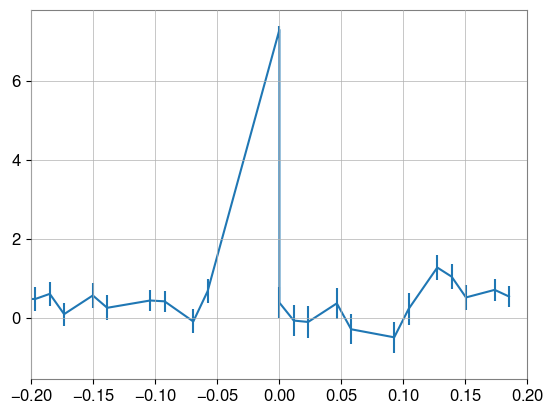

In [29]:
rmax = d_j1[d_j1['RATE'].argmax()]
rmax['TIME']

plt.errorbar(
    d_j2['TIME'] - rmax['TIME'],
    d_j2['RATE'],
    d_j2['ERROR']
)

plt.xlim([-0.2, 0.2])

requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/IJD/{rmax['TIME']}/SCWID").json()

/home/savchenk/miniconda-recent/lib/python3.9/site-packages/gwpy/plot/axes.py:78: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  return func(self, **kw)


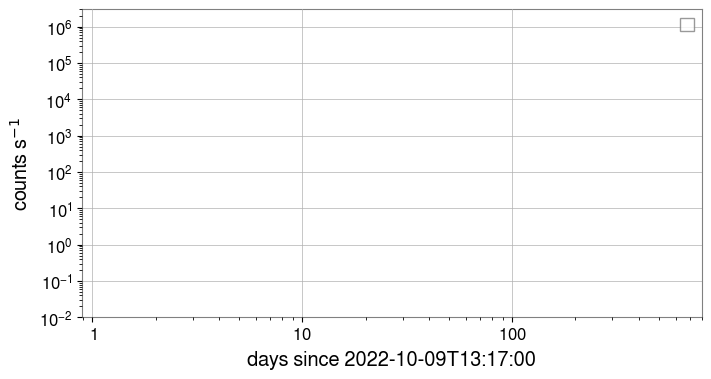

In [30]:
from statistics import mode

plt.figure(figsize=(8,4))


plt.xlabel(f"days since {T0_isot}")

# plt.axvspan(Time("2022-10-10 13:27:56").mjd - 51544 - T0_ijd, Time("2022-10-10 14:27:28").mjd - 51544 - T0_ijd, alpha=0.2)
# plt.axvspan(Time("2022-10-10 15:02:00").mjd - 51544 - T0_ijd, Time("2022-10-11 04:19:48").mjd - 51544 - T0_ijd, alpha=0.2)


if False:
    from scipy.optimize import minimize

    # minimize()l
    t_model = lambda t, N, slope: N*t**slope
    slope = -1.3
    t_model_noslope = lambda t, N: N*t**slope_0

    def loss(p):
        if len(p) == 1:
            N, = p
            slope = -1.3
        else:
            N, slope = p
            
        d = np.concatenate([
            (t_model(d_j1['TIME'] - T0_ijd, N, slope) - d_j1['RATE']) / d_j1['ERROR'],
            (t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR']
        ])
        

        m = d**2 < np.percentile(d**2, 95)

        # print(N, slope, (d**2).sum(), d_j1[d.argmax()], d_j1[d.argmin()])
        # plt.plot(d_j1['TIME'], d**2)
        return np.sum(d[m]**2) # + \
            #    np.sum(((t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR'])**2) + \
            #    np.sum(((t_model(d_i['TIME'] - T0_ijd, N, slope) - d_i['RATE']) / d_i['ERROR'])**2)

    slope_fitted = slope
    N_fitted, = minimize(loss, [1]).x
    # N_fitted, slope_fitted = minimize(loss, [N_fitted, slope]).x


    t = np.logspace(-1.5, 1, 100) + 200
    plt.plot(t, t_model(t, N_fitted, slope_fitted), ls="--", label=f'fit to JEM-X and ISGRI light curves, slope={slope_fitted:.3g}, N={N_fitted:.2g}')


xrt_norm = 1e3

# t = np.logspace(np.log10(T0bat.mjd - 51544 - T0_ijd), 1, 100)  
# plt.plot(t, xrt_norm*xrt_decay(t*24*3600)*1e8, label="XRT decay", lw=3, ls="-", c='k', alpha=0.5)

plt.legend()

plt.loglog()

plt.xlim([0, 800])
plt.ylim([1e-2, 3e6])

# plt.xlim([-0., 0.5])
# plt.ylim([-300, 300])


# ax_x_hours = plt.twiny()

# plt.ylabel("erg cm$^{-2}$ s$^{-1}$")
plt.ylabel("counts s$^{-1}$")
plt.savefig("figs/joint_lc.png")
# plt.savefig("grb221009-picture/spiacs-lc.png")

# https://www.swift.ac.uk/burst_analyser/01126853/
# https://gcn.gsfc.nasa.gov/gcn3/32671.gcn3

In [31]:
if False:
    # from statistics import mode

    plt.rc('font', size=16) #controls default text size
    plt.rc('axes', titlesize=16) #fontsize of the title
    plt.rc('axes', labelsize=16) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
    plt.rc('legend', fontsize=16) #fontsize of the legend

    d_j1 = source_products['jemx1_lc'].jemx_lc_0_GRB221009A.data_unit[2].data 
    d_j2 = source_products['jemx2_lc'].jemx_lc_0_GRB221009A.data_unit[2].data 
    d_i = source_products['isgri_lc'].isgri_lc_3_GRB221009A.data_unit[1].data

    plt.figure(figsize=(12,7))

    tail_change = 670

    m = acslc.t  - T0_ijd > 247/24/3600
    m &= acslc.t  - T0_ijd < tail_change/24/3600

    m_acs_long = acslc.t  - T0_ijd > -200/24/3600
    m_acs_long &= acslc.t  - T0_ijd < 0.1


    c = plt.plot(
        (acslc.t - T0_ijd)[m],
        (acslc.c - bkg)[m]/acs_scale,
        # alpha=0.2,
        label="SPI-ACS",
        lw=3
    )[0].get_color()

    # n = 500
    # c = plt.errorbar(
    #         (rebin(acslc.t[m], n)/n - T0_ijd),
    #         (rebin(acslc.c[m], n)/n - bkg - F((rebin(acslc.t[m], n)/n - T0_ijd)*24, *curve[0]))/acs_scale,
    #         # (rebin(acslc.c, n)/n - bkg - F((rebin(acslc.t, n)/n - T0_ijd)*24, *curve[0]))
    #         (rebin(acslc.c[m], n))**0.5/n/acs_scale
    #     )[0].get_color()

    tail_change = 0.005
    T = np.logspace(np.log10(tail_change), -1.1, 100)
    T = np.logspace(np.log10(tail_change), -1.1, 100)

    # T = np.concatenate([np.linspace(0, tail_change, int(tail_change/(tail_bins[1] - tail_bins[0]))), tail_bins])

    Tc, dT, C, CE = rebin_bins_in_bins(acslc.t - T0_ijd, np.ones_like(acslc.t)*0.05/24/3600/2, acslc.c, acslc.c**0.5, T)

    C = C - bkg - F(Tc*24, *curve[0])
    # c = 'blue'
    c = plt.errorbar(Tc, C/acs_scale, CE/acs_scale, c=c, xerr=dT, ls="", lw=3)[0].get_color()
    plt.step(Tc, C/acs_scale, c=c, where='mid', lw=3)



    # for d, f, n in [
    #     (d_j1, 1, 'JEMX1'),
    #     (d_j2, 1, 'JEMX2'),
    #     # (d_i, 0.01, 'ISGRI'),
    # ]:    
    #     plt.errorbar(
    #         d['TIME'] - T0_ijd, 
    #         f*d['RATE'], 
    #         f*d['ERROR'], 
    #         xerr=d['TIMEDEL']/2, ls="", label=n)



    for n, g in rebinned_lc_by_name.items():
        m = g['X'] / g['dX'] > -10

        if n.lower().startswith('jemx'):
            scale = 0.15/(1e-8/200)
        else:
            scale = 1/(1e-8/200)

        plt.errorbar(
                g['Tc'][m],
                g['X'][m]/scale,
                np.max(np.stack([g['dX'], g['X']*0.2]), axis=0)[m]/scale, # observed jemx systematics included
                xerr=g['dT'][m],
                label=n,
                ls="",
                lw=4.
            )

    font = {'fontname':'serif'}

    plt.loglog()
    plt.xlim([200./24/3600, 3])
    plt.xlabel(f"days since {T0_isot.replace('T', ' ')} (T$_0$)", **font)

    # plt.axvspan(Time("2022-10-10 13:27:56").mjd - 51544 - T0_ijd, Time("2022-10-10 14:27:28").mjd - 51544 - T0_ijd, alpha=0.2)
    # plt.axvspan(Time("2022-10-10 15:02:00").mjd - 51544 - T0_ijd, Time("2022-10-11 04:19:48").mjd - 51544 - T0_ijd, alpha=0.2)

    np.sum(d['TIMEDEL'])*24*3600


    if False:
        from scipy.optimize import minimize

        # minimize()l
        t_model = lambda t, N, slope: N*t**slope
        slope = -1.3
        t_model_noslope = lambda t, N: N*t**slope_0

        def loss(p):
            if len(p) == 1:
                N, = p
                slope = -1.3
            else:
                N, slope = p
                
            d = np.concatenate([
                (t_model(d_j1['TIME'] - T0_ijd, N, slope) - d_j1['RATE']) / d_j1['ERROR'],
                (t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR']
            ])
            

            m = d**2 < np.percentile(d**2, 95)

            # print(N, slope, (d**2).sum(), d_j1[d.argmax()], d_j1[d.argmin()])
            # plt.plot(d_j1['TIME'], d**2)
            return np.sum(d[m]**2) # + \
                #    np.sum(((t_model(d_j2['TIME'] - T0_ijd, N, slope) - d_j2['RATE']) / d_j2['ERROR'])**2) + \
                #    np.sum(((t_model(d_i['TIME'] - T0_ijd, N, slope) - d_i['RATE']) / d_i['ERROR'])**2)

        slope_fitted = slope
        N_fitted, = minimize(loss, [1]).x
        # N_fitted, slope_fitted = minimize(loss, [N_fitted, slope]).x


        t = np.logspace(-1.5, 1, 100) + 200
        plt.plot(t, t_model(t, N_fitted, slope_fitted), ls="--", label=f'fit to JEM-X and ISGRI light curves, slope={slope_fitted:.3g}, N={N_fitted:.2g}')


    xrt_norm = 1e3

    # t = np.logspace(np.log10(T0bat.mjd - 51544 - T0_ijd), 1, 100)  
    # plt.plot(t, xrt_norm*xrt_decay(t*24*3600)*1e8, label="XRT decay", lw=3, ls="-", c='k', alpha=0.5)

    plt.legend(loc='lower left')
    plt.ylabel("erg cm$^{-2}$ s$^{-1}$")

    plt.xlim([2e-3, 15])
    # plt.ylim([1e-2, 3e6])

    # plt.xlim([-0., 0.5])
    # plt.ylim([-300, 300])


    # ax_x_hours = plt.twiny()

    # plt.rcParams["figure.figsize"] = [7.00, 3.50]
    # plt.rcParams["figure.autolayout"] = True

    im = plt.imread(f'pom/grb-light-{focus_obs_name}.png') # insert local path of the image.
    newax = plt.gcf().add_axes([0.50,0.45,1.0,0.50], anchor='SW', zorder=1)
    newax.imshow(im)
    newax.axis('off')


    im = plt.imread(f'pom/grb-light-r2560.png') # insert local path of the image.
    newax = plt.gcf().add_axes([0.70,0.34,0.9,0.34], anchor='SW', zorder=1)
    newax.imshow(im)
    newax.axis('off')


    plt.savefig("figs/joint_lc.png")
    plt.savefig(f"pom/composite-light-{focus_obs_name}.png")
    # plt.savefig(f"pom/composite-light-multiobs.png")

    # https://www.swift.ac.uk/burst_analyser/01126853/
    # https://gcn.gsfc.nasa.gov/gcn3/32671.gcn3

In [32]:
!ls -lotr jemxX*

-rw-rw-r-- 1 savchenk 8182080 Feb 11 22:46 jemxX_mosaic.fits
-rw-rw-r-- 1 savchenk 7534080 Feb 11 22:47 jemxX_r2559_mosaic.fits


Invalid DATE-END format 'UTC_format''. [astropy.wcs.wcs]
Invalid DATE-END format 'UTC_format''.


{'isgri': {'exposure_s': 67351.82759768004}, 'jemx1': {'exposure_s': 89212.4747163125, 'snr': 12.4718599319458}, 'jemx2': {'exposure_s': 85939.4863106728, 'snr': 12.168052673339844}, 'joint_fit': {'e1_keV': 3, 'e2_keV': 80, 'flux_ecs': 4.4263e-10, 'flux_ecs_err_68p': (-2.113000000000001e-11, 2.437000000000004e-11), 'slope': 2.15041, 'slope_err_90p': (-0.0712388, 0.0841283)}, 'obs': {}, 'telapse_sum_s': 119376.07927856734, 'telapse_total_s': 127275.08452868205, 'tstart_ijd': 8319.56830667189, 'tstop_ijd': 8321.04139792801}


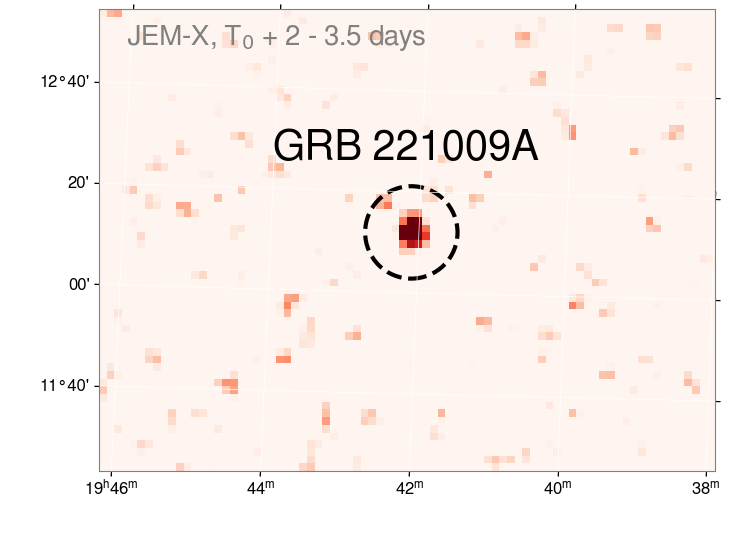

In [33]:
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# focus_obs_name = "total_3p"
# focus_obs_name = "r2560"

filename = f'jemxX_{focus_obs_name}_mosaic.fits'
# filename = 'jemxX_mosaic.fits'

hdu = fits.open(filename)[5]
wcs = WCS(hdu.header)

(x, y), = wcs.all_world2pix([[src_coord.ra.deg, src_coord.dec.deg]], 1)
i= int(y)
j= int(x)

scope = 30
scope_w = 40

plt.figure(figsize=(8,6))
plt.subplot(projection=wcs)

cut = hdu.data[i-scope:i+scope, j-scope_w:j+scope_w]
SNR = cut.max() / np.std(cut)

plt.imshow(cut, vmin=1, vmax=4, origin='lower', cmap='Reds')
plt.grid(color='white', ls='solid')
# plt.xlim([src_coord.ra.deg - 1, src_coord.ra.deg + 1])
# plt.ylim([src_coord.dec.deg - 1, src_coord.dec.deg + 1])
# plt.xlabel('RA')
# plt.ylabel('Dec')
plt.xlabel(' ')
plt.ylabel(' ')


# plt.gca().xaxis.set_label_coords(1.2, -20)

# plt.text(src_coord.ra.deg, src_coord.dec.deg, "GRB 221009A")
# plt.text(22, 40, f"GRB 221009A (S/N = {SNR})", size=30)
plt.text(22, 40, f"GRB 221009A", size=30)

ijd2isot = lambda x: Time(x+51544, format='mjd').isot
ijd2dayssince = lambda x:((x-T0_ijd))

with DraftData(focus_obs_name) as dd:
    print(dd)
    plt.text(3, 55, f'JEM-X, T$_0$ + {ijd2dayssince(dd["tstart_ijd"]):.2g} - {ijd2dayssince(dd["tstop_ijd"]):.2g} days', size=20,
            color='grey')
    # plt.title(f'Combined JEM-X image {ijd2dayssince(dd["tstart_ijd"]):.2g} - {ijd2dayssince(dd["tstop_ijd"]):.2g} days since T$_0$')

plt.gca().set_xticklabels([])
plt.gca().set_yticks([])
# plt.gca().add_patch(plt.Circle((40,30), 6, fill=False, lw=3, ls='--'))
plt.gca().add_patch(plt.Circle((40,30.5), 6, fill=False, lw=3, ls='--'))
plt.savefig(f"pom/grb-light-{focus_obs_name}.png")

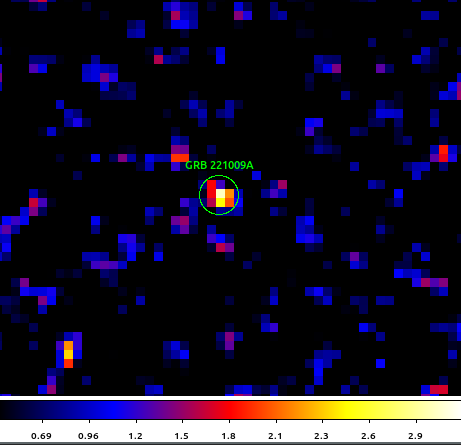

In [34]:
from IPython.display import Image

Image('jemx-p3.png')

In [35]:
with obs_draft_data as dd:
    dd['T0_isot'] = T0_isot
    dd['tstart_isot'] = Time(d_j1['TIME'].min()+51544, format='mjd').isot
    dd['tstart_since_t0'] = d_j1['TIME'].min() - T0_ijd
    dd['tstop_isot'] = Time(d_j1['TIME'].max()+51544, format='mjd').isot
    dd['tstop_since_t0'] = d_j1['TIME'].max() - T0_ijd
    dd['ontime_s'] = np.sum(d_j1['TIMEDEL'])*24*3600

In [36]:
fns

['isgri_r2559_mosaic.fits',
 'jemx1_r2559_mosaic.fits',
 'jemx2_r2559_mosaic.fits',
 'jemx1_mosaic.fits',
 'jemx2_mosaic.fits',
 'isgri_mosaic.fits',
 'isgrihe_mosaic.fits',
 ('./JMX1_lc_GRB221009A.fits', 59863.58333335401, 59865.018518535115, -1),
 ('./JMX2_lc_GRB221009A.fits', 59863.58333335401, 59865.018518535115, -1),
 ('./IBIS_lc_GRB221009A.fits',
  59863.63077342818,
  59865.04424753273,
  829.512492907919),
 ('./JMX1_spectrum_GRB221009A_r2559.fits',
  59863.56830667189,
  59865.000159474104,
  89212.4747163125),
 './JMX1_rmf_GRB221009A_r2559.fits',
 './JMX1_arf_GRB221009A_r2559.fits',
 ('./JMX2_spectrum_GRB221009A_r2559.fits',
  59863.56830667189,
  59865.000159474104,
  85939.4863106728),
 './JMX2_rmf_GRB221009A_r2559.fits',
 './JMX2_arf_GRB221009A_r2559.fits',
 ('./IBIS_spectrum_GRB221009A_r2559.fits',
  59863.61336457238,
  59865.04139792801,
  67351.82759768004),
 './IBIS_rmf_GRB221009A_r2559.fits',
 './IBIS_arf_GRB221009A_r2559.fits']

In [37]:
fits_pack_fn = "fits_files.tar"

import tarfile
with tarfile.open(fits_pack_fn, "w") as tar:
    for fn in fns:
        if isinstance(fn, tuple):
            tar.add(fn[0])
        else:
            tar.add(fn)
        

In [38]:
with tarfile.open(fits_pack_fn) as tar:
    tar.extractall()

In [39]:
dd

{'isgri': {'exposure_s': 67351.82759768004},
 'jemx1': {'exposure_s': 89212.4747163125, 'snr': 12.4718599319458},
 'jemx2': {'exposure_s': 85939.4863106728, 'snr': 12.168052673339844},
 'joint_fit': {'e1_keV': 3,
  'e2_keV': 80,
  'flux_ecs': 4.4263e-10,
  'flux_ecs_err_68p': (-2.113000000000001e-11, 2.437000000000004e-11),
  'slope': 2.15041,
  'slope_err_90p': (-0.0712388, 0.0841283)},
 'obs': {},
 'telapse_sum_s': 119376.07927856734,
 'telapse_total_s': 127275.08452868205,
 'tstart_ijd': 8319.56830667189,
 'tstop_ijd': 8321.04139792801,
 'T0_isot': '2022-10-09T13:17:00',
 'tstart_isot': '2022-10-11T14:08:20.002',
 'tstart_since_t0': 2.0356481667840853,
 'tstop_isot': '2022-10-13T00:18:20.002',
 'tstop_since_t0': 3.4592592778972175,
 'ontime_s': 78999.97219200002}

In [40]:
with obs_draft_data as dd:
    dd['scheduled_obs'] = {
        'T1_isot': '2022-10-11 13:52:21',
        'T2_isot': '2022-10-13 00:58:26'
    }
    dd['scheduled_obs_p3'] = {
        'T1_isot': '2022-10-14 20:42:27',
        'T2_isot': '2022-10-16 04:47:41',
        'ref': 'https://www.cosmos.esa.int/web/integral/schedule-information'
    }

    dd['ixpe_obs'] = {
        'T1_isot': '2022-10-11T23:34:28',
        'T2_isot': '2022-10-14T00:45:31',
        'ref': 'https://www.astronomerstelegram.org/?read=15678' 
    }

In [41]:
T0_scwid=requests.get("https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/converttime/UTC/2022-10-09T13:17:00/SCWID").text.strip()

In [42]:
with DraftData() as dd:
    dd['sc'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{T0_isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()

dd['sc']

{'barytime': 0.14860478635175947,
 'bodies': {'earth': {'body_dec': -69.422,
   'body_distance': 0,
   'body_in_sc': [96.70700691257376, -177.92729061769077],
   'body_ra': 19.505999999999972,
   'body_size': 2.6519059844215565,
   'integral_parallax': 57.29577951308232,
   'separation': 137648.7},
  'moon': {'body_dec': -69.422,
   'body_distance': 378263.6197848711,
   'body_in_sc': [107.42311113501043, 175.44388878344608],
   'body_ra': 19.505999999999972,
   'body_size': 0.2257527511911254,
   'integral_parallax': 17.889794313691343,
   'separation': 440848.53225096094},
  'sun': {'body_dec': -69.422,
   'body_distance': 149429798.59580338,
   'body_in_sc': [67.89812327806959, -3.2523349448476337],
   'body_ra': 19.505999999999972,
   'body_size': 0.2668117335302039,
   'integral_parallax': 0.0527904100405045,
   'separation': 149396255.10412204}},
 'd_scx': 65.81131216259752,
 'd_scy': 148.90559844165924,
 'd_scz': 108.32307498976417,
 'dyz_scy': 159.8406485434722,
 'dyz_scz': 110

In [43]:
with obs_draft_data as dd:
    pass

In [44]:
# dd.update(ddpaper.draftdata.dump_notebook_globals("glbs", globals()))

In [45]:
dd['obs']

{}

In [46]:
data = dd
lc_jemx1_grb221009a = "figs/lc_jemx1_grb221009a.pdf"
lc_jemx2_grb221009a = "figs/lc_jemx2_grb221009a.pdf"
lc_isgri_grb221009a = "figs/lc_isgri_grb221009a.pdf"
fits_pack = fits_pack_fn

In [47]:

import papermill as pm
import scrapbook as sb
import base64
import json
import hashlib
import os
    
from nb2workflow.nbadapter import denumpyfy
from nb2workflow.json import CustomJSONEncoder


try:
    sb.glue("data",denumpyfy(data))
except Exception as e:
    print("failed to glue data", data)
    print("will glue jsonified")
    sb.glue("data",json.dumps(denumpyfy(data), cls=CustomJSONEncoder))

if isinstance(data,str) and os.path.exists(data):
    variable_name = "data"
    fn = data
    content = open(fn ,'rb').read()    

    if 1048576 is None or len(content) < 1048576:
        encoded = base64.b64encode(content).decode()
        print("glueing file", fn)
        sb.glue(variable_name + "_content", encoded)
    else:
        # TODO: make a customizable upload to different DL platforms; before that it should be enabled with caution    
        os.makedirs("/tmp/nb2w-store", exist_ok=True)
        url = "file:///tmp/nb2w-store/" + str(hashlib.md5(content).hexdigest())
        print("storing file to URL", url)
        with open(url.replace("file://", ""), "wb") as f:
            f.write(content)

        sb.glue("data_url", url)


try:
    sb.glue("lc_jemx1_grb221009a",denumpyfy(lc_jemx1_grb221009a))
except Exception as e:
    print("failed to glue lc_jemx1_grb221009a", lc_jemx1_grb221009a)
    print("will glue jsonified")
    sb.glue("lc_jemx1_grb221009a",json.dumps(denumpyfy(lc_jemx1_grb221009a), cls=CustomJSONEncoder))

if isinstance(lc_jemx1_grb221009a,str) and os.path.exists(lc_jemx1_grb221009a):
    variable_name = "lc_jemx1_grb221009a"
    fn = lc_jemx1_grb221009a
    content = open(fn ,'rb').read()    

    if 1048576 is None or len(content) < 1048576:
        encoded = base64.b64encode(content).decode()
        print("glueing file", fn)
        sb.glue(variable_name + "_content", encoded)
    else:
        # TODO: make a customizable upload to different DL platforms; before that it should be enabled with caution    
        os.makedirs("/tmp/nb2w-store", exist_ok=True)
        url = "file:///tmp/nb2w-store/" + str(hashlib.md5(content).hexdigest())
        print("storing file to URL", url)
        with open(url.replace("file://", ""), "wb") as f:
            f.write(content)

        sb.glue("lc_jemx1_grb221009a_url", url)


try:
    sb.glue("lc_jemx2_grb221009a",denumpyfy(lc_jemx2_grb221009a))
except Exception as e:
    print("failed to glue lc_jemx2_grb221009a", lc_jemx2_grb221009a)
    print("will glue jsonified")
    sb.glue("lc_jemx2_grb221009a",json.dumps(denumpyfy(lc_jemx2_grb221009a), cls=CustomJSONEncoder))

if isinstance(lc_jemx2_grb221009a,str) and os.path.exists(lc_jemx2_grb221009a):
    variable_name = "lc_jemx2_grb221009a"
    fn = lc_jemx2_grb221009a
    content = open(fn ,'rb').read()    

    if 1048576 is None or len(content) < 1048576:
        encoded = base64.b64encode(content).decode()
        print("glueing file", fn)
        sb.glue(variable_name + "_content", encoded)
    else:
        # TODO: make a customizable upload to different DL platforms; before that it should be enabled with caution    
        os.makedirs("/tmp/nb2w-store", exist_ok=True)
        url = "file:///tmp/nb2w-store/" + str(hashlib.md5(content).hexdigest())
        print("storing file to URL", url)
        with open(url.replace("file://", ""), "wb") as f:
            f.write(content)

        sb.glue("lc_jemx2_grb221009a_url", url)


try:
    sb.glue("lc_isgri_grb221009a",denumpyfy(lc_isgri_grb221009a))
except Exception as e:
    print("failed to glue lc_isgri_grb221009a", lc_isgri_grb221009a)
    print("will glue jsonified")
    sb.glue("lc_isgri_grb221009a",json.dumps(denumpyfy(lc_isgri_grb221009a), cls=CustomJSONEncoder))

if isinstance(lc_isgri_grb221009a,str) and os.path.exists(lc_isgri_grb221009a):
    variable_name = "lc_isgri_grb221009a"
    fn = lc_isgri_grb221009a
    content = open(fn ,'rb').read()    

    if 1048576 is None or len(content) < 1048576:
        encoded = base64.b64encode(content).decode()
        print("glueing file", fn)
        sb.glue(variable_name + "_content", encoded)
    else:
        # TODO: make a customizable upload to different DL platforms; before that it should be enabled with caution    
        os.makedirs("/tmp/nb2w-store", exist_ok=True)
        url = "file:///tmp/nb2w-store/" + str(hashlib.md5(content).hexdigest())
        print("storing file to URL", url)
        with open(url.replace("file://", ""), "wb") as f:
            f.write(content)

        sb.glue("lc_isgri_grb221009a_url", url)


try:
    sb.glue("fits_pack",denumpyfy(fits_pack))
except Exception as e:
    print("failed to glue fits_pack", fits_pack)
    print("will glue jsonified")
    sb.glue("fits_pack",json.dumps(denumpyfy(fits_pack), cls=CustomJSONEncoder))

if isinstance(fits_pack,str) and os.path.exists(fits_pack):
    variable_name = "fits_pack"
    fn = fits_pack
    content = open(fn ,'rb').read()    

    if 1048576 is None or len(content) < 1048576:
        encoded = base64.b64encode(content).decode()
        print("glueing file", fn)
        sb.glue(variable_name + "_content", encoded)
    else:
        # TODO: make a customizable upload to different DL platforms; before that it should be enabled with caution    
        os.makedirs("/tmp/nb2w-store", exist_ok=True)
        url = "file:///tmp/nb2w-store/" + str(hashlib.md5(content).hexdigest())
        print("storing file to URL", url)
        with open(url.replace("file://", ""), "wb") as f:
            f.write(content)

        sb.glue("fits_pack_url", url)



<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:105: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:132: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:105: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:132: SyntaxWarning: "is" with a literal. Did you mean "=="?


/tmp/ipykernel_2264320/3545823784.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 1048576 is None or len(content) < 1048576:


glueing file figs/lc_jemx1_grb221009a.pdf


/tmp/ipykernel_2264320/3545823784.py:51: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 1048576 is None or len(content) < 1048576:


glueing file figs/lc_jemx2_grb221009a.pdf


/tmp/ipykernel_2264320/3545823784.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 1048576 is None or len(content) < 1048576:


glueing file figs/lc_isgri_grb221009a.pdf


/tmp/ipykernel_2264320/3545823784.py:105: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 1048576 is None or len(content) < 1048576:


/tmp/ipykernel_2264320/3545823784.py:132: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 1048576 is None or len(content) < 1048576:


storing file to URL file:///tmp/nb2w-store/58d3988c03768147945ed720bfde53e4
